In [20]:
import setup
import numpy as np
import pandas as pd
from thalpy.constants import paths
from matplotlib import pyplot as plt
from thalpy.analysis import masks
from thalpy import base

masker = masks.get_binary_mask(masks.MOREL_PATH)

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogrammasks

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hier_cluster(task_matrix, n_clusters=None):
    if n_clusters is None:
        distance_threshold = 0
    else:
        distance_threshold = None
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    cluster = model.fit(np.mean(task_matrix, axis=2).swapaxes(0, 1))
    if distance_threshold is not None:
        plot_dendrogram(model, truncate_mode='level', p=3)
    return cluster



In [21]:
# task_matrix, tstat_task_matrix, masker = setup.setup_mdtb('block', is_setup_block=True)
# zscored_task_matrix = setup.zscore_subject_2d(task_matrix)

MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
MDTB_DIR_TREE = base.DirectoryTree(MDTB_DIR)
MDTB_ANALYSIS_DIR = MDTB_DIR + 'analysis/'
stim_config_df = pd.read_csv(MDTB_DIR + paths.DECONVOLVE_DIR + paths.STIM_CONFIG)
CONDITIONS_LIST = stim_config_df["Stim Label"].tolist()
TASK_LIST = list(set(stim_config_df["Group"].to_list()))

# conditions_matrix, tstat_conditions_matrix, masker = setup.setup_mdtb('_norest', is_setup_block=False)
# zscored_mdtb_matrix = setup.zscore_subject_2d(conditions_matrix)
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy', zscored_mdtb_matrix)

zscored_mdtb_matrix = np.load(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy')

In [24]:
from thalpy.constants import paths

print(zscored_mdtb_matrix.shape)
conditions_cluster = hier_cluster(zscored_mdtb_matrix, n_clusters=7)
# dendrogram(conditions_cluster)

for k in np.arange(len(np.unique(conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(CONDITIONS_LIST) if k == conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')

(2227, 45, 21)
k: 0  group: ['NatureMovie', 'AnimatedMovie', 'VideoActions', 'Rest']
k: 1  group: ['Go', 'SpatialMapMed', 'SpatialMapHard', 'MentalRotHard', 'RespAltEasy', 'RespAltMed', 'RespAltHard', 'FingerSeq']
k: 2  group: ['DigitJudgement', 'IntervalTiming', 'MotorImagery', 'StroopIncon', 'StroopCon', 'Verbal2Back', 'SpatialImagery', 'WordRead']
k: 3  group: ['LandscapeMovie', 'MentalRotEasy', 'MentalRotMed', 'BiologicalMotion', 'ScrambledMotion', 'VideoKnots', 'VisualSearchHard']
k: 4  group: ['UnpleasantScenes', 'PleasantScenes', 'Objects', 'SadFaces', 'HappyFaces']
k: 5  group: ['NoGo', 'Math', 'SpatialMapEasy', 'PermutedRules', 'Prediction', 'PredictViol', 'PredictScram', 'FingerSimple', 'Object2Back', 'VisualSearchEasy', 'VisualSearchMed']
k: 6  group: ['TheoryOfMind', 'VerbGen']


/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


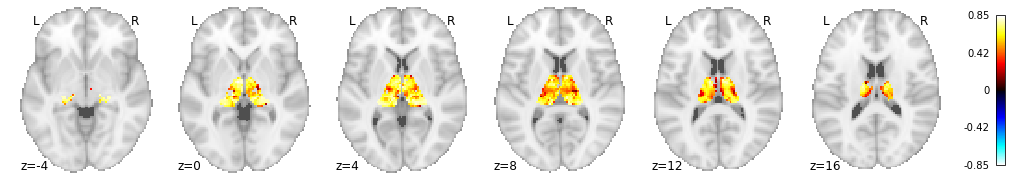

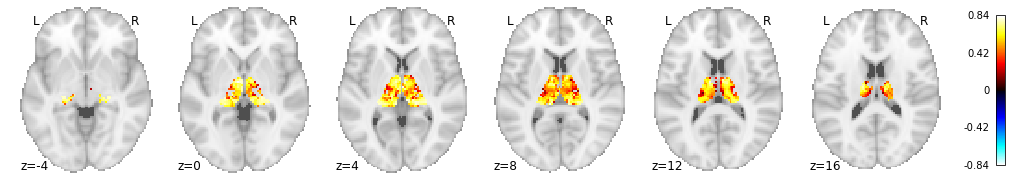

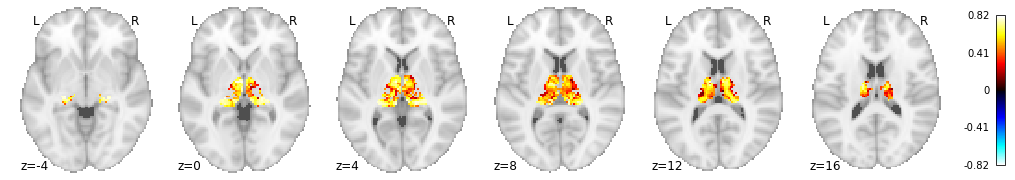

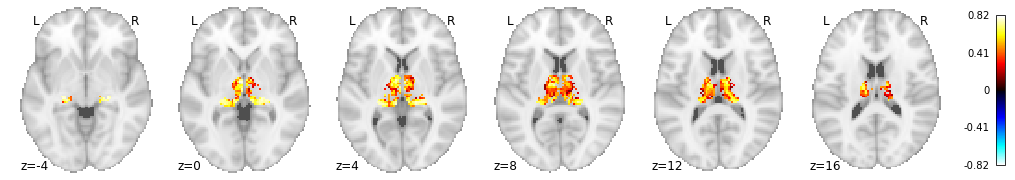

In [25]:
from thalpy.analysis import pc, plotting

thresholds = [70, 75, 80, 85]
pc_matrix = pc.pc_subject(np.mean(zscored_mdtb_matrix, axis=2), conditions_cluster.labels_, thresholds=thresholds)

for i, threshold in enumerate(thresholds):
    pc_img = masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)

Explained variance:
[0.37853541 0.26294348 0.11643497 0.04552019 0.03593157 0.02187392
 0.01479299 0.01191073 0.00899699 0.00820668 0.00679811 0.00666879
 0.0061303  0.00601228 0.00547644 0.00480191 0.00458898 0.00401905
 0.00365302]


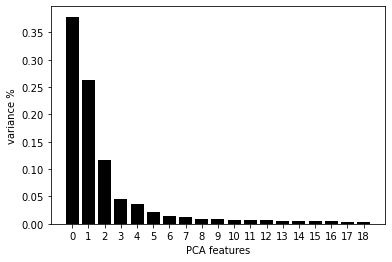

768 -0.062337  0.124824  0.046310 -0.234571   
Verbal2Back      -0.124464 -0.211924 -0.012317  0.320871  0.130916 -0.013588   
NatureMovie      -0.034789 -0.003615  0.030269 -0.034892  0.112145  0.018279   
LandscapeMovie   -0.078494 -0.100672  0.056894  0.031563  0.083285 -0.054986   
AnimatedMovie    -0.214911 -0.094453  0.007077  0.142279  0.218320  0.212509   
SpatialMapEasy    0.089086  0.100015 -0.022613 -0.063371 -0.046497 -0.055026   
SpatialMapMed    -0.017837  0.011952  0.041510  0.001189  0.065175 -0.090257   
SpatialMapHard   -0.090307 -0.052559  0.044263  0.083539  0.074732  0.046240   
MentalRotEasy    -0.160025 -0.024314  0.021270 -0.059816 -0.067283 -0.135634   
MentalRotMed     -0.112401  0.085582 -0.090763  0.005035 -0.085943 -0.030068   
MentalRotHard    -0.241178  0.015103 -0.048490  0.133144 -0.087947 -0.026562   
RespAltEasy       0.016475  0.151928  0.096820 -0.296364  0.096660  0.044969   
RespAltMed        0.092216  0.000994  0.149029 -0.280851  0.120625  0.011

array([[ 0.81218721, -1.42186668, -0.8777217 , ..., -0.2733461 ,
        -0.13365342,  0.09449261],
       [ 0.94202838, -2.06433445, -0.59636974, ..., -0.24174785,
        -0.00915161,  0.1076838 ],
       [ 0.58298459, -0.51191947, -1.05067681, ..., -0.04759554,
        -0.09669857, -0.35203198],
       ...,
       [ 1.53074519, -0.68917963, -0.05034151, ..., -0.13046713,
         0.16698877,  0.21208601],
       [ 1.73205498, -1.39732609,  0.9613957 , ..., -0.18400482,
         0.00228077,  0.04292497],
       [ 1.57862414, -1.67567727,  1.14916714, ..., -0.3732764 ,
        -0.15676812,  0.05878243]])

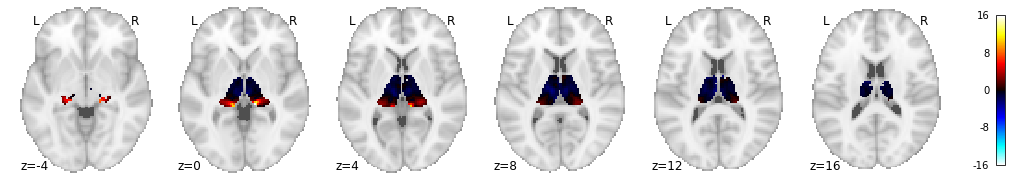

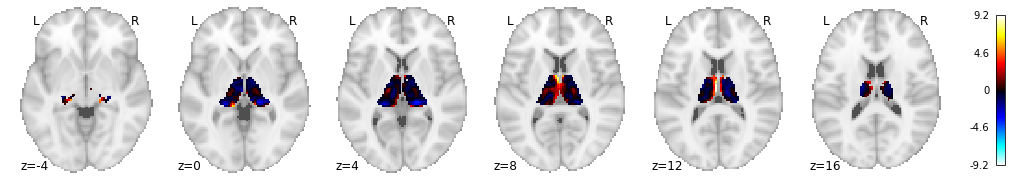

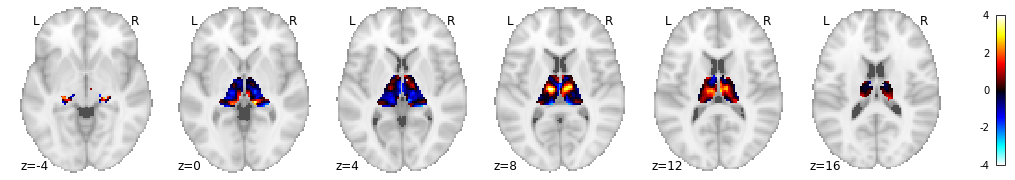

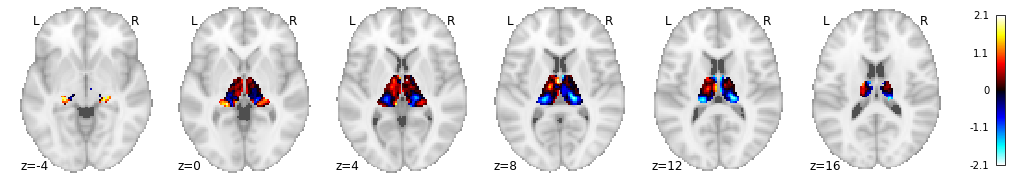

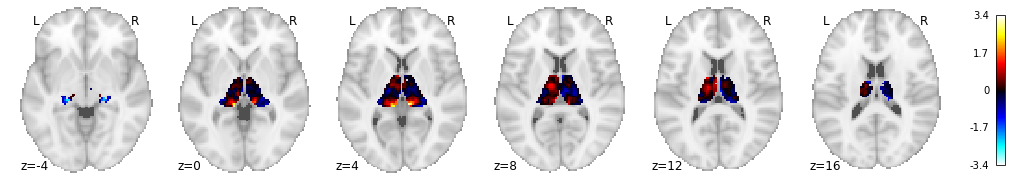

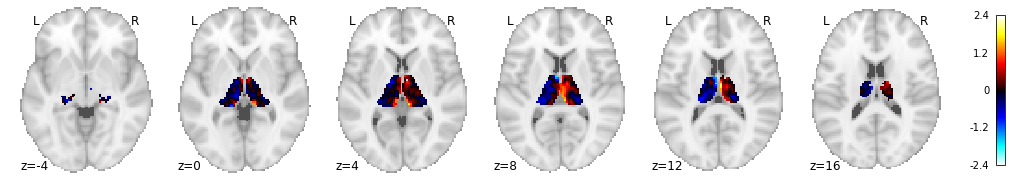

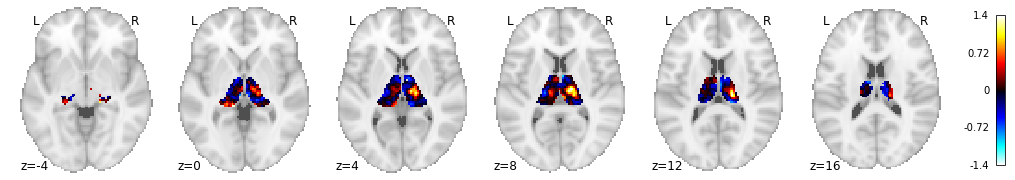

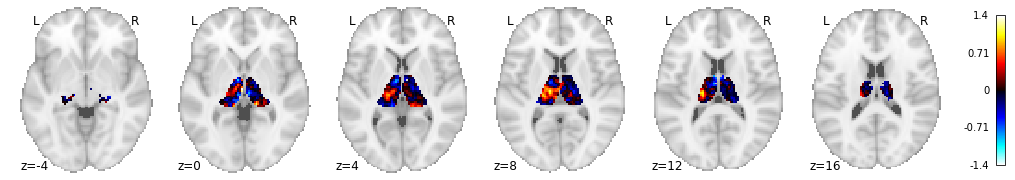

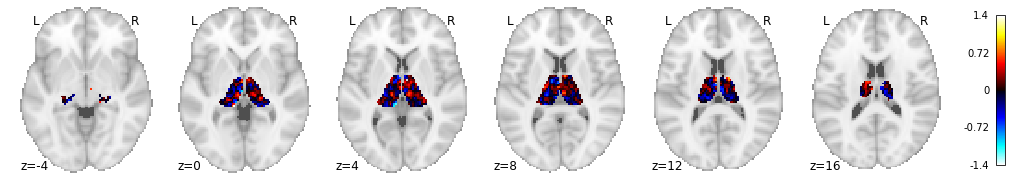

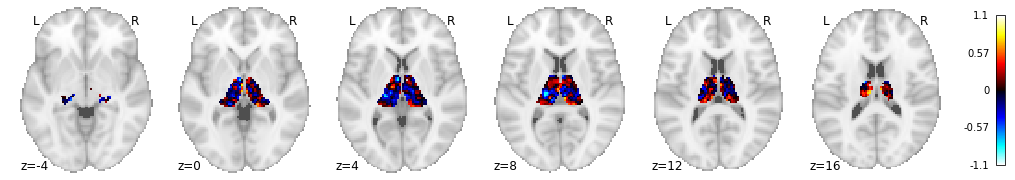

In [27]:
os.chdir(MDTB_DIR_TREE.analysis_dir)
feature_extraction.compute_PCA(np.mean(zscored_mdtb_matrix, axis=2), masker=masker, output_name='pca_mdtb', var_list=CONDITIONS_LIST)

In [22]:

IBC_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/IBC/"
IBC_CONDITIONS_DF = pd.read_csv(
    "/mnt/nfs/lss/lss_kahwang_hpc/scripts/ibc_authors/ibc_data/conditions.tsv",
    sep="\t",
)
IBC_CONDITIONS_DF.at[253, "contrast"] = "null"
IBC_GLM_DIR = IBC_DIR + "glm/"
IBC_DIR_TREE = base.DirectoryTree(IBC_DIR) 

# setup.setup_ibc() -> run if npy array isnt saved yet
ibc_conditions = np.load(IBC_GLM_DIR + 'ibc_conditions.npy')
filtered_ibc = []
print(ibc_conditions.shape)
for condition_index in np.arange(ibc_conditions.shape[1]):
    if np.all(ibc_conditions[:, condition_index, :] == 0):
        IBC_CONDITIONS_DF = IBC_CONDITIONS_DF.drop(condition_index)
    else:
        filtered_ibc.append(ibc_conditions[:, condition_index, :])

filtered_ibc_matrix = np.swapaxes(np.swapaxes(np.stack(filtered_ibc), 1, 2), 0, 1)
print(filtered_ibc_matrix.shape)

zscored_ibc_conditions = setup.zscore_subject_2d(filtered_ibc_matrix)
print(zscored_ibc_conditions.shape)


(13, 262, 2227)
(2227, 160, 13)
0.0023271732886959544
10.398784893441158
5.5961744320938515e-18
(2227, 160, 13)


In [7]:

ibc_conditions_cluster = hier_cluster(zscored_ibc_conditions, n_clusters=7)
# plot_dendrogram(ibc_conditions_cluster)

for k in np.arange(len(np.unique(ibc_conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(IBC_CONDITIONS_DF['contrast'].to_numpy()) if k == ibc_conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')



k: 0  group: ['saccades', 'rotation_hand', 'rotation_side', 'object_grasp', 'object_orientation', 'mechanistic_audio', 'mechanistic_video', 'triangle_mental', 'triangle_random', 'false_belief_audio', 'false_belief_video', 'speech_sound', 'non_speech_sound', 'face_gender', 'face_control', 'face_trusty', 'expression_intention', 'expression_gender', 'expression_control', 'shape', 'face', 'punishment', 'reward', 'story', 'math', 'relational', 'match', 'mental', 'random', '0back_body', '2back_body', '0back_face', '2back_face', '0back_tools', '2back_tools', '0back_place', '2back_place', 'food_constant', 'food_linear', 'food_quadratic', 'painting_constant', 'painting_linear', 'painting_quadratic', 'face_constant', 'face_linear', 'face_quadratic', 'house_constant', 'house_linear', 'house_quadratic', 'vstm_linear', 'vstm_constant', 'vstm_quadratic', 'talk', 'no_talk', 'foveal', 'middle', 'peripheral', 'unattend', 'attend', 'random_string', 'word', 'pseudoword', 'letter_occurrence_response', '2_

[ 6.71343429e-01  5.48442438e-01  6.51469362e-01 ...  6.87116273e-01
  6.35048318e-01 -1.33226763e-15]
/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(
[ 6.60370893e-01  5.41850023e-01  6.52252367e-01 ...  6.58630838e-01
  5.84683279e-01 -1.33226763e-15]
[ 6.60228383e-01  0.00000000e+00  4.84091126e-01 ...  6.45413238e-01
  4.45520819e-01 -1.33226763e-15]
[ 0.00000000e+00  0.00000000e+00 -4.44089210e-16 ...  4.99738462e-01
 -4.44089210e-16 -4.44089210e-16]


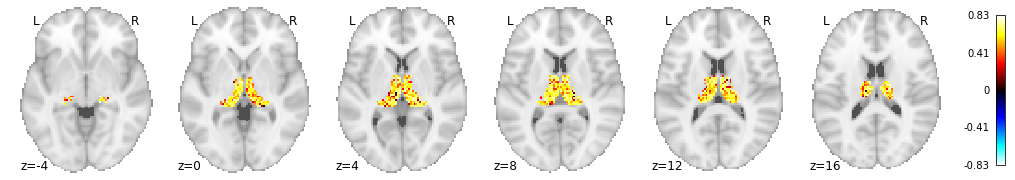

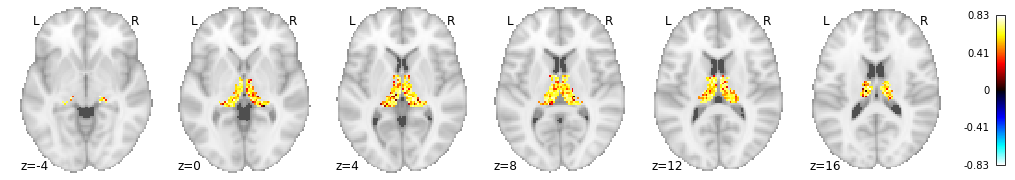

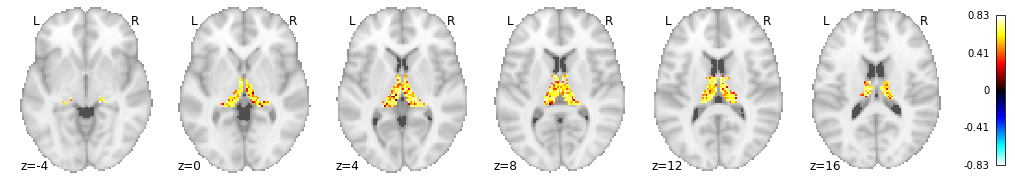

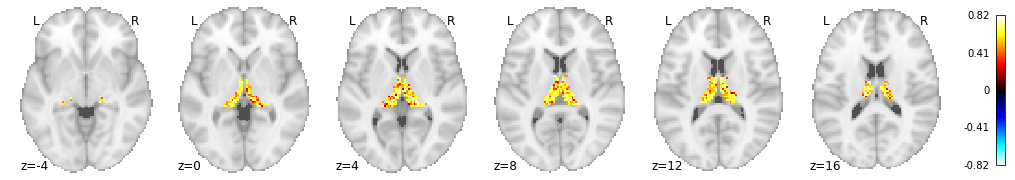

In [8]:
from thalpy.analysis import pc, plotting

thresholds = [70, 75, 80, 85]
ibc_pc_matrix = pc.pc_subject(np.mean(zscored_ibc_conditions, axis=2), ibc_conditions_cluster.labels_,thresholds=thresholds)

for i, threshold in enumerate(thresholds):
    print(ibc_pc_matrix[:, i])
    pc_img = masker.inverse_transform(ibc_pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)

Explained variance:
[0.52859219 0.14127216 0.10500599 0.09649206 0.02423655 0.01985639
 0.01818437 0.01559675 0.01086973]


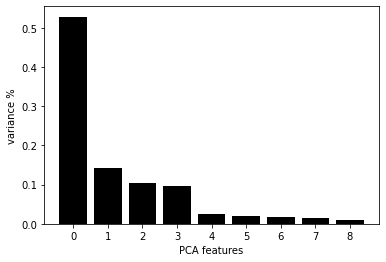

                                      0         1         2         3  \
audio_left_button_press        0.002113 -0.001062  0.208658 -0.235394   
audio_right_button_press       0.002113 -0.001062  0.208658 -0.235394   
video_left_button_press        0.002113 -0.001062  0.208658 -0.235394   
video_right_button_press       0.002113 -0.001062  0.208658 -0.235394   
horizontal_checkerboard        0.002113 -0.001062  0.208658 -0.235394   
...                                 ...       ...       ...       ...   
incorrect_cue_incorrect_probe  0.000141  0.000607 -0.006888 -0.005129   
ambiguous_intermediate         0.000215 -0.005554 -0.009095  0.003631   
unambiguous_direct             0.000215 -0.005554 -0.009095  0.003631   
ambiguous_direct               0.000215 -0.005554 -0.009095  0.003631   
unambiguous_intermediate       0.000215 -0.005554 -0.009095  0.003631   

                                      4         5         6         7  \
audio_left_button_press       -0.007100 -0.007932 

array([[ 0.22264996,  0.25281343, -0.06655232, ..., -0.07254814,
        -0.02839337,  0.01434954],
       [-0.11575004, -0.07446108, -0.02448999, ...,  0.02561087,
        -0.05051743, -0.05413398],
       [-0.07389687,  0.13991883, -0.12942261, ...,  0.08366541,
        -0.04794334, -0.07283498],
       ...,
       [-0.51045003,  0.25568055, -0.09154507, ...,  0.07357328,
        -0.03833479, -0.01560692],
       [-0.00248722, -0.12632279, -0.05079746, ...,  0.00507512,
        -0.0528418 , -0.05008288],
       [-0.14920949,  0.04059863, -0.07826959, ...,  0.0114909 ,
        -0.00373779, -0.01509067]])

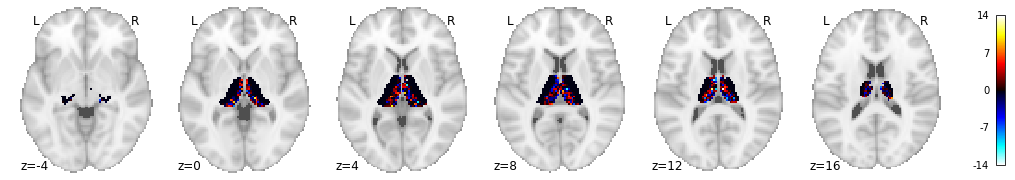

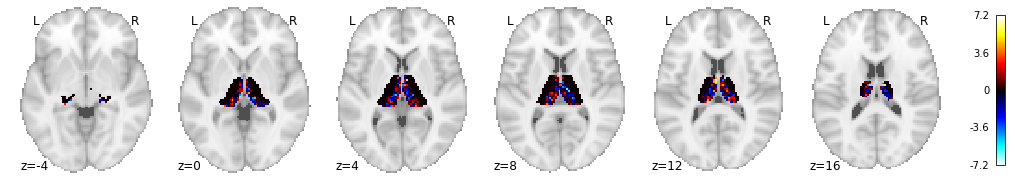

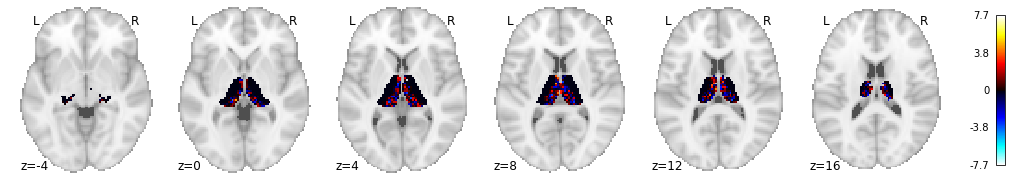

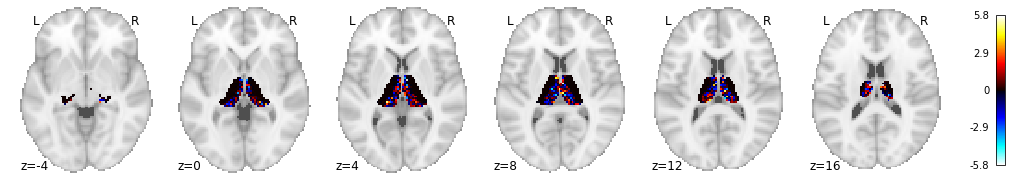

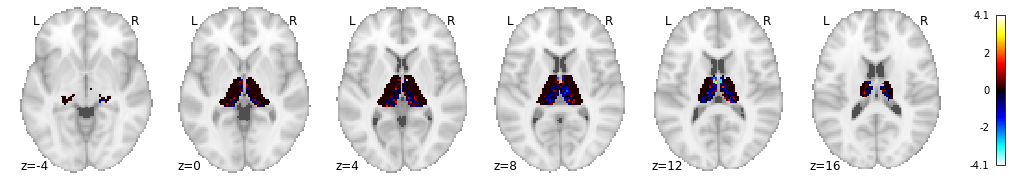

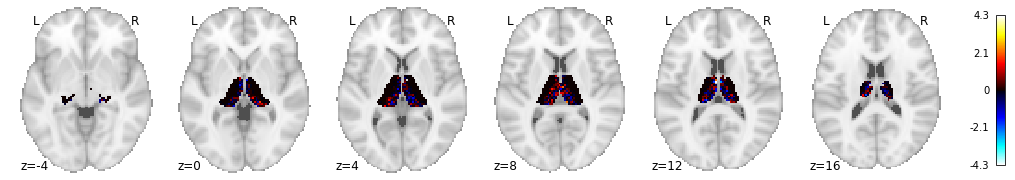

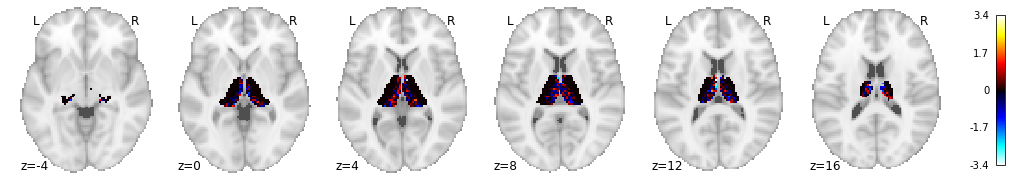

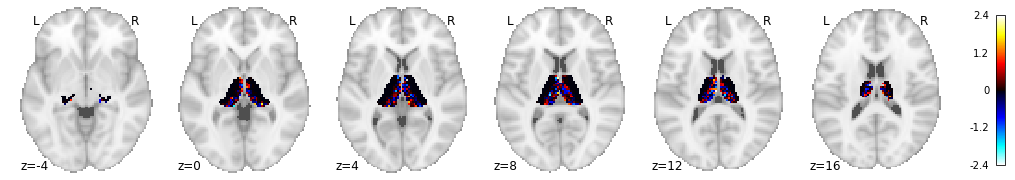

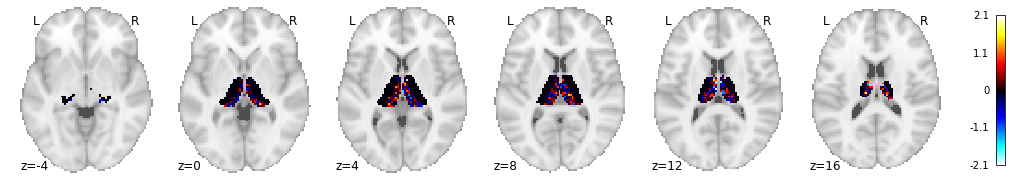

In [9]:
from thalpy.analysis import feature_extraction

os.chdir(IBC_DIR_TREE.analysis_dir)
feature_extraction.compute_PCA(np.mean(zscored_ibc_conditions, axis=2), masker=masker, output_name='pca_ibc', var_list=IBC_CONDITIONS_DF['contrast'].to_numpy())

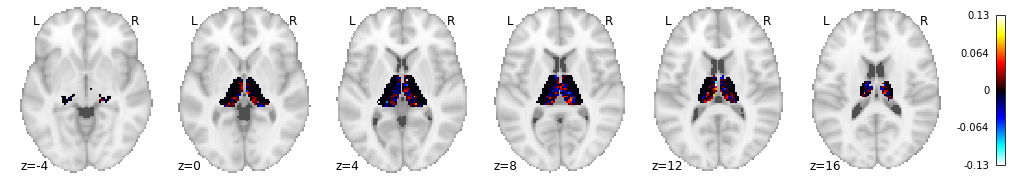

In [18]:
avg_wm_matrix = np.mean(zscored_ibc_conditions[:, IBC_CONDITIONS_DF.loc[IBC_CONDITIONS_DF['task'] == 'hcp_wm'].index, :], axis=2)
avg_wm_matrix = np.mean(avg_wm_matrix, 1)
img = masker.inverse_transform(avg_wm_matrix)

plotting.plot_thal(img)

